## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models II
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, any figures you find useful, together with your answers.
* Please submit your report as a single PDF file, named according to: `name1_name2_name3_LabLinearModelsI.pdf`.
* We recommend working in a group of 4–5 students (max 6); the report does not have to be submitted by every group member -- one submission per group is sufficient.

**Group Members:** Mamoun Alaoui Slimani, Léa Slive, Yasaman Noorikhah, Antonio Del Priore Antunes  
**Date of Submission:** Thursday, October 2, 2025

Please find the answer of each question written as a markdown or code cell after the question.

In [1]:
%matplotlib widget

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample, welch, correlate
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.ar_model import AutoReg

# File paths
fhr1 = os.path.join(os.getcwd(), 'data', 'heart_1.dat')
fhr2 = os.path.join(os.getcwd(), 'data', 'heart_2.dat')
fem1 = os.path.join(os.getcwd(), 'data', 'emg1.dat')
fem2 = os.path.join(os.getcwd(), 'data', 'emg2.dat')
fppg = os.path.join(os.getcwd(), 'data', 'ppg.dat')
feeg = os.path.join(os.getcwd(), 'data', 'eeg_stim.dat')

### Experiment 1: parametric spectral estimation of cardiorespiratory signals
The file `/data/heart_1.dat` contains three physiological signals: RR-interval, arterial pressure and respiration, in this order (sampled at 4 Hz). The recordings were made in a patient at rest. In the spectral domain, this RR-interval signal is expected to show a peak around 0.08 Hz, corresponding to the *baroreflex* (regulation between arterial blood pressure and heart rate), and a peak at 0.225 Hz, corresponding to the *breathing rate* (heart rhythm modulation by respiration, the so-called *“sinus arrhythmia”*) – see `/data/readme_heart.txt` for more details.

We start by importing the signals, subsampling to 1 Hz, and removing their averages:

In [2]:
with open(fhr1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr1 = np.array([float(s[0]) for s in txt])
    bp1 = np.array([float(s[1]) for s in txt])
    rs1 = np.array([float(s[2]) for s in txt])

df = 4
rr1 = resample(rr1, int(len(rr1)/df))
bp1 = resample(bp1, int(len(bp1)/df))
rs1 = resample(rs1, int(len(rs1)/df))

for y in [rr1, bp1, rs1]:
    y -= np.mean(y)

AR modeling provides tools for extracting various useful estimates from a signal, in a so-called *parametric* way, because the estimates are based on the model parameters, rather than on the raw signal itself. The function defined below implements the estimation of the signal spectral density based on its AR parameters.

In [3]:
'''
def ar_psd(arg1, arg2, arg3, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        arg1: ?
        arg2: ?
        arg3: ?
        n: defines the spectral sampling
    
    Outputs:
        arg4: ?
        arg5: ?
    """
    
    arg5 = np.arange(n) * arg3/2/n
    aar, sg = yule_walker(arg1, order=arg2, method="mle")
    
    a = complex(1)
    for k in range(1,arg2+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*arg5/arg3)
    
    arg4 = sg**2 / (arg3 * np.abs(a)**2)
    
    return arg4, arg5
'''

'\ndef ar_psd(arg1, arg2, arg3, n=1000):\n    """\n    Parametric spectral density estimation based on AR modeling\n\n    Inputs:\n        arg1: ?\n        arg2: ?\n        arg3: ?\n        n: defines the spectral sampling\n\n    Outputs:\n        arg4: ?\n        arg5: ?\n    """\n\n    arg5 = np.arange(n) * arg3/2/n\n    aar, sg = yule_walker(arg1, order=arg2, method="mle")\n\n    a = complex(1)\n    for k in range(1,arg2+1):\n        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*arg5/arg3)\n\n    arg4 = sg**2 / (arg3 * np.abs(a)**2)\n\n    return arg4, arg5\n'

**Question 1.1.** The implementation above has an incomplete docstring (help text), and the input and output arguments have generic names (`arg1-5`). Copy the function to the answer space below, complete the help, and replace the argument names by more intuitive choices, based on what you've learned in the theory.

**Answer 1.1.** `Write your answer here`

In [4]:
def ar_psd(x, order, fs, nfreq=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        x: 1-D signal (demeaned recommended).
        order: AR model order (p).
        fs: sampling frequency in Hz.
        nfreq: number of frequency points for the PSD grid (default 1000).

    Outputs:
        psd: AR-based PSD estimate (power/Hz) sampled on f.
        f: frequency vector in Hz, from 0 to fs/2 with nfreq points.
    """
    f = np.arange(nfreq) * fs / 2 / nfreq
    aar, sg = yule_walker(x, order=order, method="mle")
    a = complex(1)
    for k in range(1, order+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*f/fs)
    psd = sg**2 / (fs * np.abs(a)**2)
    return psd, f

#### We now use this tool to obtain the spectral density of the three signals. Below, we explore the results obtained with different AR model orders: 5, 15, 40.

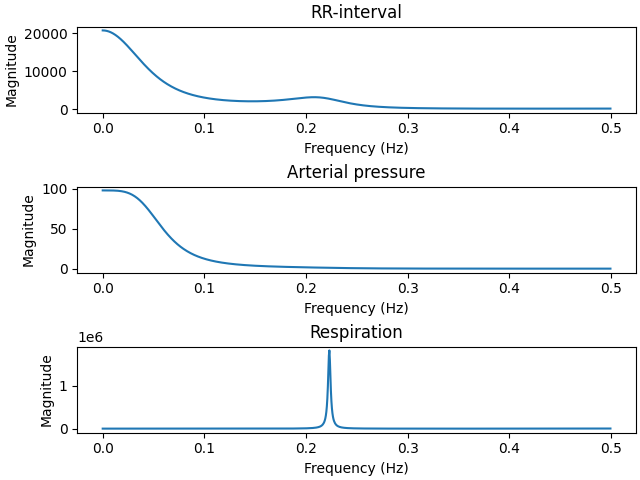

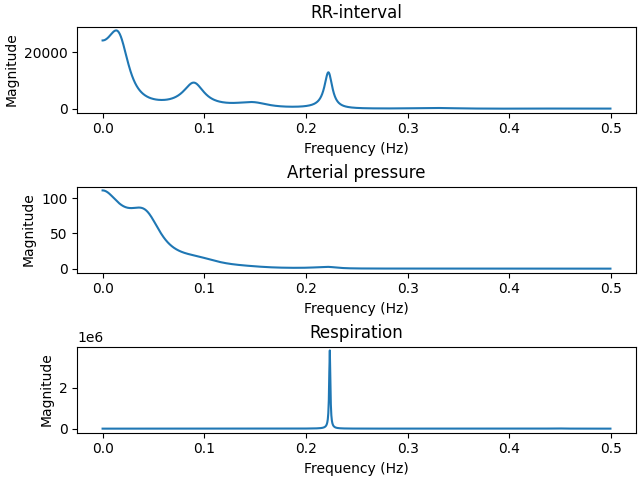

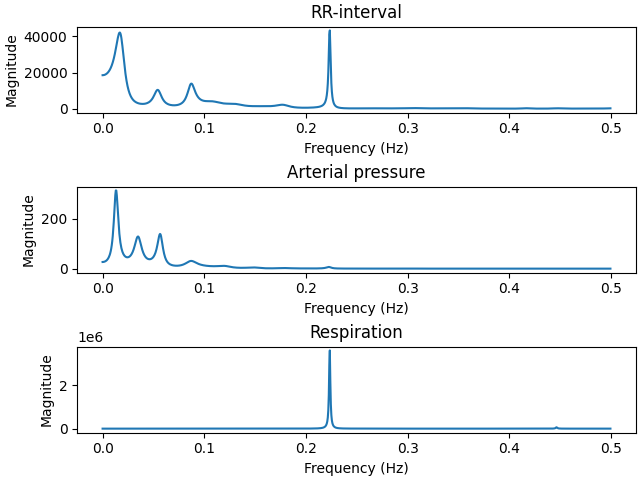

In [5]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

for p in (5, 15, 40):
    
    plt.figure(constrained_layout=True)
    
    for k in range(3):
        
        py, f = ar_psd(y[k], p, 1.0)
        
        plt.subplot(3,1,k+1)
        plt.plot(f, py)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(ttl[k])

**Question 1.2.** How does the order affect the spectra? Given the physiological description of the expected peaks for the RR-interval, what is the most suitable order choice?

**Answer 1.2.** Higher order increases the frequency resolution in the smoother regions. In the higher order model, we can see features that are not visible in the lower order ones. 
For example, the low frequencies present an elevated magnitude region in the low order, but that becomes 3 different peaks in the higher order. Notice also that the magnitudes of the peaks are on average higher when the order of the model is higher. This means that low order models smooth/merge peaks and is a sign that the higher order models are overfitting. 

For the RR-interval, the best choice would be around order 15, which resolves the physiologically expected ~0.08 Hz and ~0.225 Hz peaks without overfitting.

We can now perform a *non-parametric* spectral estimation of the same signals, using for instance Welch’s method:

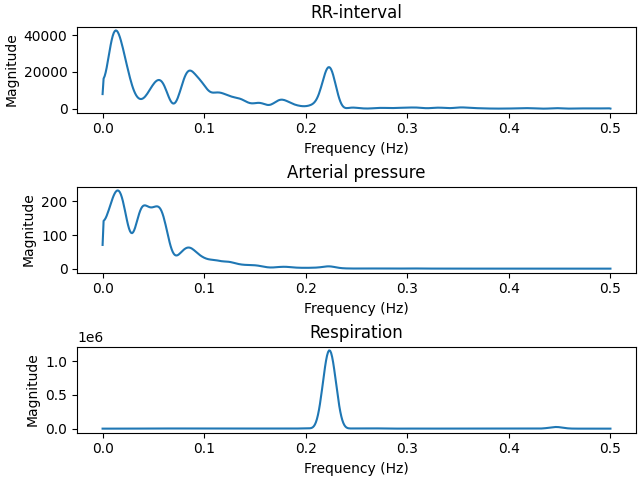

In [6]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)

for k in range(3):
    
    f, py = welch(y[k], fs=1.0, nperseg=100, scaling='density', nfft=1000)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])


**Question 1.3.** Explain how Welch's method works (it may be helpful to consult the help of `welch`), and the fundamental differences between this approach and the AR parametric method.

**Answer 1.3.** Welch's method is a non-parametric PSD estimator,and it works by splitting the signal into overlapping, windowed segments, then computing the periodograms of each segment, and finally averaging them to reduce variance; it generally presents wider peaks. 
AR is parametric: it fits a low-order model to autocorrelation, and generally yields smoother PSD with potentially sharper peaks, but depends on the chosen order. As we can see from the figure the resolution is satisfactory and the peaks are not too high. This means that the model is not overfitting, and works well for all RR-interval, Arterial pressure and Respiration.



**Question 1.4.** In our particular problem, how do the spectra obtained with Welch's method compare with those of the parametric approach (order 15)? Given the previous RR-interval description, which approach performs most reliably?

**Answer 1.4.** The Welch method shows broader peaks and lower variance; AR(15) shows sharper peaks near 0.08 Hz and 0.225 Hz. For the physiologicsal scope of this experiment, for short, narrowband content, the AR model of order 15 is more reliable here.

We now consider the signals in `/data/heart_2.dat`, which are recordings from the same individual after alcohol consumption.

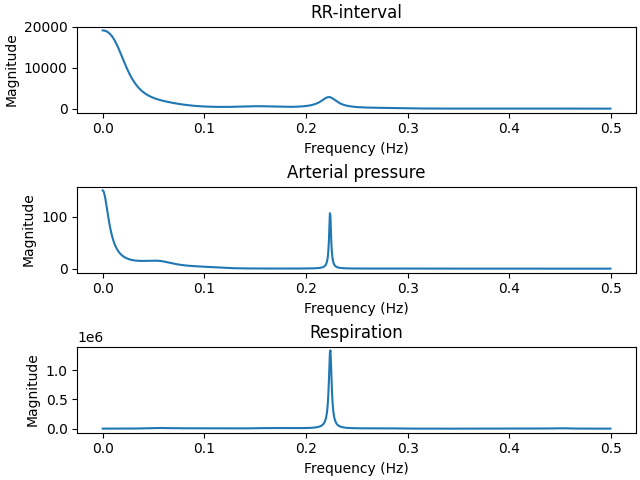

In [7]:
with open(fhr2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr2 = np.array([float(s[0]) for s in txt])
    bp2 = np.array([float(s[1]) for s in txt])
    rs2 = np.array([float(s[2]) for s in txt])

df = 4
rr2 = resample(rr2, int(len(rr2)/df))
bp2 = resample(bp2, int(len(bp2)/df))
rs2 = resample(rs2, int(len(rs2)/df))

for y in [rr2, bp2, rs2]:
    y -= np.mean(y)
    
    
y = [rr2, bp2, rs2]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']


plt.figure(constrained_layout=True)

p = 15
for k in range(3):
    
    py, f = ar_psd(y[k], p, 1.0)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])
plt.show()
    

**Question 1.5.** Repeat the processing steps done for `heart_1.dat` to obtain a parametric spectral estimation (order 15). Which of the physiological mechanisms described for the RR-interval was most disrupted by alcohol? And what other changes do you observe in the physiological signals?

**Answer 1.5.** The ~0.08 Hz baroreflex peak is much attenuated and almost invisible after the assumption of alcohol. The ~0.225 Hz breathing rate peak is still visible, although also attenuated. Therefore the baroreflex is the most disrupted physiological mechanism here.
In the respiration graph, we see that the only peak is still at the same frequency, although its magnitude is also lower than the peak on the other sample. 
Regarding the Arterial pressure graph, the lower region of the frequencies are much attenuated, while there is a new peak that appeared at the same frequency of ~0.225 Hz for the other two graphs.

### Experiment 2: estimating the effects of fatigue on muscle signals
The files `/data/emg1.dat` and `/data/emg2.dat` contain three surface electromyography (sEMG) signals each (1024 Hz sampling frequency). These signals were recorded from the thigh muscle during a 10-min exercise on an ergocycle, respectively from an athlete (`emg1`) and from a moderately trained subject (`emg2`). In each file, the columns correspond to recordings from the *start*, *middle* and *end* of the exercise, respectively.

We start by importing the signals:

In [8]:
with open(fem1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em1 = np.zeros((n,3))
    for k in range(3):
        em1[:,k] = [float(s[k]) for s in txt]

with open(fem2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em2 = np.zeros((n,3))
    for k in range(3):
        em2[:,k] = [float(s[k]) for s in txt]

fs = 1024.0 # Hz

We first plot the sEMG segments in the time domain. We can observe four bursts in each recording, which correspond to four pedal strokes. The goal of the experiment was to assess the effects of fatigue on the signal properties of the sEMG.

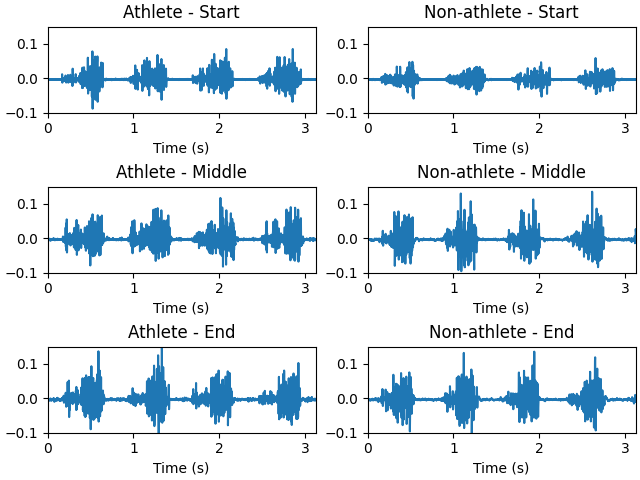

In [9]:
ttl1 = ['Athlete', 'Non-athlete']
ttl2 = ['Start', 'Middle', 'End']
t = np.arange(n) / fs

plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    
    for l in range(3):
        
        plt.subplot(3,2,2*l+k+1)
        plt.plot(t,y[:,l])
        plt.xlim(t[0], t[-1])
        plt.ylim(-0.10, 0.15)
        plt.xlabel('Time (s)')
        plt.title(ttl1[k] + ' - ' + ttl2[l])

We'll now look at the spectral profile of the signals. Considering, for instance, the start sEMG recording of the athlete, we obtain the parametric power spectral density (PSD) for an AR model of order 30:

**Question 2.1.** In principle, it would be more correct to segment each burst and analyze it separately, but it turns out that using the entire recording will yield a relatively similar spectral profile. Check that it is the case: copy the plotting code above to the space below and add (overlayed in the same panel) the PSD obtained from the first burst only, for the same signal. How do their profiles compare? Where does the difference in peak signal-to-noise come from?

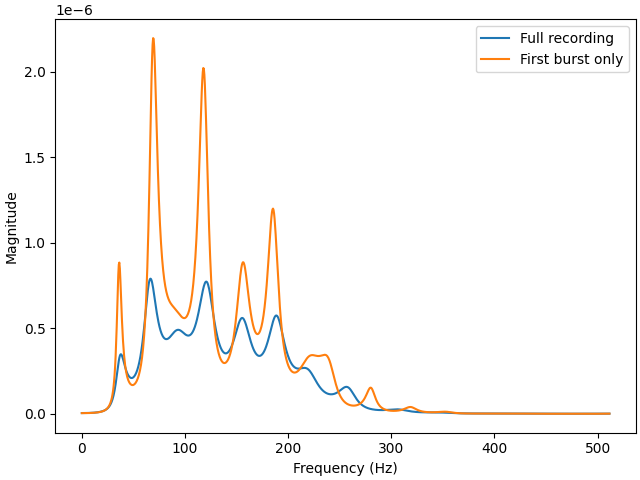

In [10]:
p = 30
full_signal = em1[:, 0]
pya_full, fa = ar_psd(full_signal, p, fs)

start_idx = int(0.15 * fs)
end_idx = int(0.67 * fs)
burst_signal = full_signal[start_idx:end_idx]

pya_burst, fa_burst = ar_psd(burst_signal, p, fs)

plt.close('all')
plt.figure(constrained_layout=True)
plt.plot(fa, pya_full, label='Full recording')
plt.plot(fa_burst, pya_burst, label='First burst only')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.show()


**Answer 2.1.** The PSDs of the full recording and of a single burst show a very similar spectral shape, confirming that the bursts dominate the signal energy. The PSD computed from a single burst shows higher peak magnitude and sharper spectral features due to the exclusion of quiescent intervals and improved signal stationarity.

We now estimate and plot the PSD for every recorded segment of both individuals:

Athlete - Start: mean frequency = 136.51 Hz
Athlete - Middle: mean frequency = 127.31 Hz
Athlete - End: mean frequency = 121.10 Hz
Non-athlete - Start: mean frequency = 106.30 Hz
Non-athlete - Middle: mean frequency = 87.91 Hz
Non-athlete - End: mean frequency = 87.61 Hz


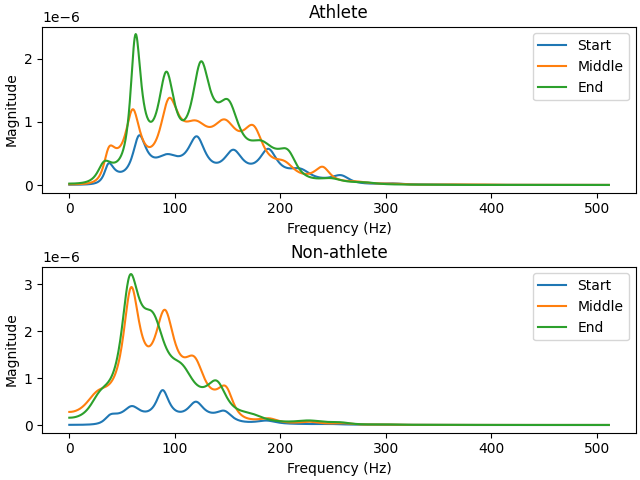

In [11]:
mean_freqs = np.zeros((2,3))
plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    plt.subplot(2,1,k+1)
    
    for l in range(3):
        
        pya, fa = ar_psd(y[:,l], p, fs)
        plt.plot(fa, pya, label=ttl2[l])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')

        mean_freqs[k,l] = np.sum(fa * pya / np.sum(pya))

    
    plt.title(ttl1[k])
    plt.legend()

for k in range(2):
    for l in range(3):
        print(f"{ttl1[k]} - {ttl2[l]}: mean frequency = {mean_freqs[k,l]:.2f} Hz")

**Question 2.2.** To complement the above PSD's, estimate the mean frequency using `sum(fa * pya / sum(pya))`. What does this formula express?

**Answer 2.2.** The formula computes the mean frequency as the power-weighted average of all frequencies in the PSD. It represents the expected value of the frequency when the PSD is treated as a probability distribution of power, thus summarizing where most of the spectral energy is concentrated.

**Question 2.3.** Based on the PSD plots and the mean frequencies obtained above, what marks the difference between the athlete and the moderately trained subject?

**Answer 2.3.** The athlete’s sEMG shows higher mean frequencies throughout the exercise and a gradual and steady decrease toward the end, while the non-athlete starts with a lower mean frequency and experiences a sharper drop, due to fatigue, by the middle of the exercise with the PSD shifting toward lower frequencies and broader peaks.

### Experiment 3: assessment of PPG signal structure
Photoplethysmography (PPG) is a simple, low-cost, non-invasive optical monitoring technique that can be used to detect volumetric changes in blood in the peripheral circulation, by measuring on the skin surface. It can be integrated in wearable devices (e.g. a watch) to monitor a person’s heart rate throughout daily life, and detect potential issues like atrial fibrillation. The file `/data/ppg.dat` contains a PPG recording from a normal cardiac rhythm, and another from a subject in atrial fibrillation (both sampled at 21.3 Hz).

We start by importing and plotting the two signals:

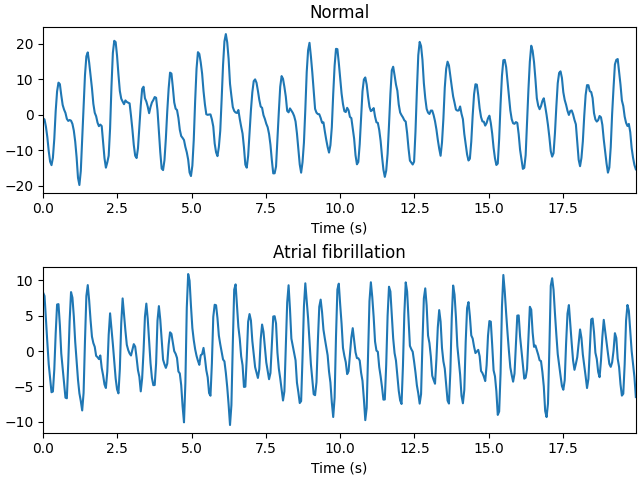

In [12]:
with open(fppg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    ppg1 = np.array([float(s[0]) for s in txt])
    ppg2 = np.array([float(s[1]) for s in txt])

for y in [ppg1, ppg2]:
    y -= np.mean(y)

fs = 21.3 # Hz

plt.figure(constrained_layout=True)
ttl = ['Normal', 'Atrial fibrillation']

n = len(ppg1)
t = np.arange(n) / fs

for k in range(2):
    
    y = [ppg1, ppg2][k]
    
    plt.subplot(2,1,k+1)
    plt.plot(t, y)
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

Each observed oscillation on the PPG typically corresponds to one pulse, generated by one cardiac cycle. By inspecting the plot above, we can already appreciate how one signal is visibly less regular than the other. AR modeling allows us to quantify the underlying differences with several complementary metrics.

We define again the function `ar_order` introduced in the previous practical session:

In [13]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), c, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 3.1.** Estimate the optimal AR model order for each signal, using the function `ar_order` above (you can set a maximal order of 40 for the search).

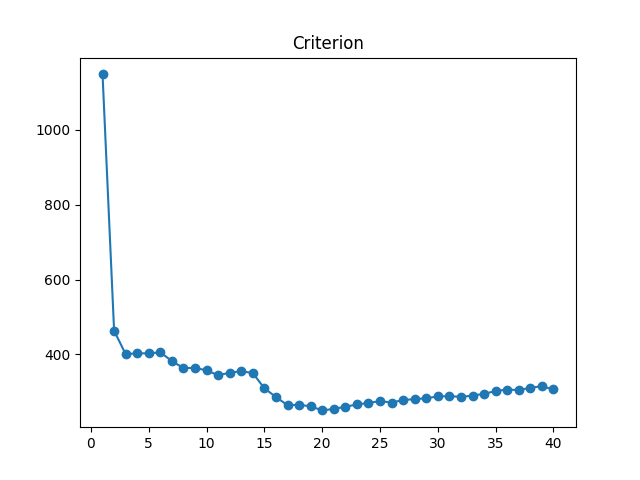

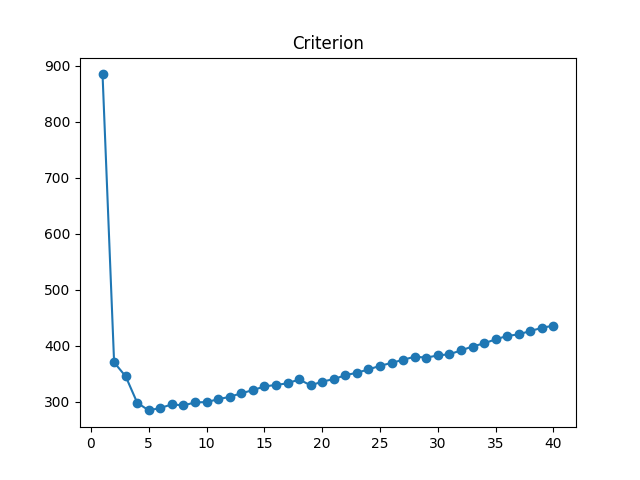

Optimal AR order (Normal PPG): 20
Optimal AR order (AF PPG): 5


In [14]:
omax = 40
omdl_ppg1, s_ppg1, c_ppg1 = ar_order(ppg1, omax, Aff=1)
omdl_ppg2, s_ppg2, c_ppg2 = ar_order(ppg2, omax, Aff=1)

print("Optimal AR order (Normal PPG):", omdl_ppg1)
print("Optimal AR order (AF PPG):", omdl_ppg2)

**Answer 3.1.** 

The optimal AR orders are the following:

For the Normal PPG: 20. 

For the AF PPG: 5

**Question 3.2.** Estimate the ratio between the excitation variance and the signal variance, for each signal (as in previous exercises, you can rely on the `yule_walker` function with `method='mle'`)

In [15]:
aar1, sg1 = yule_walker(ppg1, order=omdl_ppg1, method='mle')
ratio_ppg1 = sg1 / np.var(ppg1)

aar2, sg2 = yule_walker(ppg2, order=omdl_ppg2, method='mle')
ratio_ppg2 = sg2 / np.var(ppg2)

print("Excitation/Signal variance ratio (Normal PPG):", ratio_ppg1)
print("Excitation/Signal variance ratio (AF PPG):", ratio_ppg2)

Excitation/Signal variance ratio (Normal PPG): 0.018472400192385306
Excitation/Signal variance ratio (AF PPG): 0.07195254459933886


**Answer 3.2.** 

For the normal PPG, the ratio is: 0.01847240019238536. 

For the AF PPG, the ratio is: 0.07195254459933886

**Question 3.3.** Estimate and plot the PSD of each signal, using the `ar_psd` function for the estimates (for consistency, use the same order of 20 for both signals)

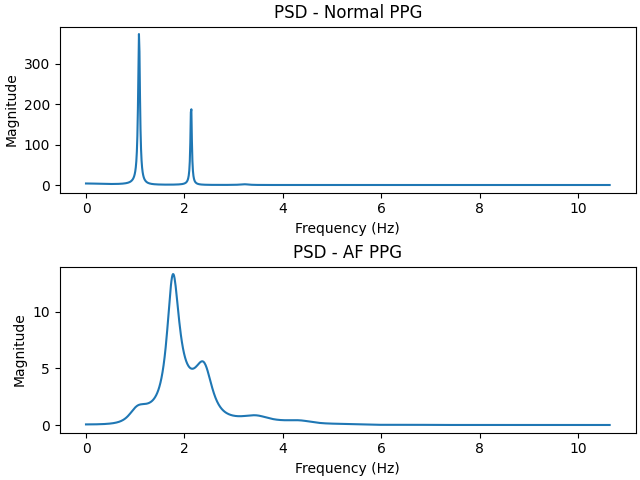

In [16]:
order = 20
psd_ppg1, f = ar_psd(ppg1, order, fs)
psd_ppg2, f = ar_psd(ppg2, order, fs)

plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(f, psd_ppg1)
plt.title('PSD - Normal PPG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.subplot(2,1,2)
plt.plot(f, psd_ppg2)
plt.title('PSD - AF PPG')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

**Answer 3.3.** `Write your answer here`

**Question 3.4.** Estimate the entropy of the PSD of each signal, using:

*p = py / sum(py)*

*entropy = sum(-p * log(p))*

where py is the vector of PSD amplitudes.

In [17]:
p1 = psd_ppg1 / np.sum(psd_ppg1)
entropy_ppg1 = -np.sum(p1 * np.log(p1))

p2 = psd_ppg2 / np.sum(psd_ppg2)
entropy_ppg2 = -np.sum(p2 * np.log(p2))

print("PSD Entropy (Normal PPG):", entropy_ppg1)
print("PSD Entropy (AF PPG):", entropy_ppg2)

PSD Entropy (Normal PPG): 4.006964138961616
PSD Entropy (AF PPG): 5.50351507010958


**Answer 3.4.** 

For the Normal PPG, the entropy of the PSD is: 4.006964138961624. 

For the AF PPG, the entropy of the PSD is: 5.50351507010958`

**Question 3.5.** What do these measures (model order, variance ratio, PSD, entropy) tell us about the two signals? Interpret what you have obtained in terms of signal structure/organization.

**Answer 3.5.** Starting with the normal PPG, the AR model selected an order of 20 and the excitation-to-signal ratio was very small. This means that the model could explain most of the signal's variability using information from many previous samples, whcih indicates that the signal is predictable.  The PSD showed two very sharp peaks, one around 1Hz and one around 2Hz, and the entropy was low (around 4). These results confirm that the normal PPG is highly organized, with most of its power concentrated at one main frequency and its harmonic. These results all lead to the conclusion that the signal is highly regular and organized.

As for the atrial fibrillation PPG, the AR model selected a lower order of 5 and the variance ratio was larger, which shows that the signal contains more random components that the model cannot capture, making it less predictable and harder to model with the AR model. The PSD was broader and had less sharp peaks, and the entropy was higher (around 5.5). This indicates a less organized and more irregular signal where energy is a little more spread over several frequencies. 

In other words, the normal PPF shows a stable, periodic rythm, while the AF PPG behaves more like a random or disordered signal. This matches the expected loss of rythmic organization in atrial fibrillation.

### Experiment 4: Pisarenko harmonic estimation of brain signals
The file `/data/eeg_stim.dat` contains three recordings of scalp electroencephalography (EEG; left frontal electrode, 4-s duration, 512 Hz sampling frequency) from a Parkinson's patient. The patient was also implanted with a deep brain stimulation (DBS) electrode. The first recording corresponds to a baseline (rest) state, the second was obtained during 1-Hz stimulation, and the third during 100-Hz stimulation.

We start by importing and plotting the three signals:

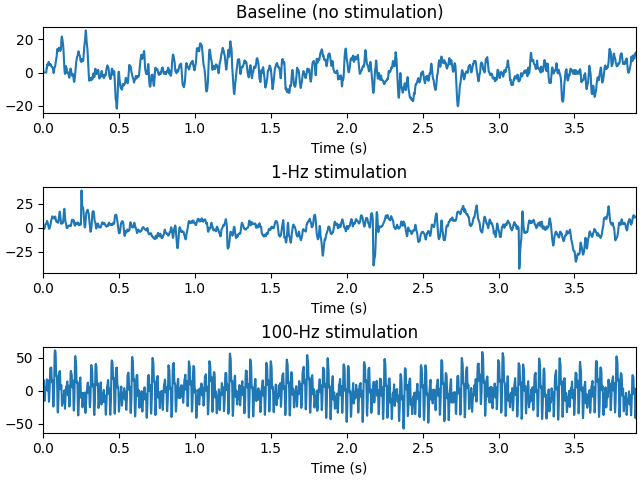

In [18]:
with open(feeg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    eeg = np.zeros((n,3))
    for k in range(3):
        eeg[:,k] = [float(s[k]) for s in txt]

fs = 512.0 # Hz

plt.figure(constrained_layout=True)
ttl = ['Baseline (no stimulation)', '1-Hz stimulation', '100-Hz stimulation']

t = np.arange(n) / fs

for k in range(3):
    plt.subplot(3,1,k+1)
    plt.plot(t, eeg[:,k])
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

**Question 4.1.** Visually, does any of the stimulation strategies appear to have an effect on the EEG? Which one(s)?

**Answer 4.1.** Visually, the 100‑Hz stimulation clearly affects the EEG; a high‑frequency sinusoidal component/artifact is visible. The 1‑Hz stimulation shows at most a subtle artifact visible at each x.2 seconds; the baseline shows no stimulation‑related oscillation.

As in previous examples, we can apply modeling techniques to quantify the physiological effects under study. Because the DBS is applied in a periodic regime with a specific frequency, it is reasonable to expect a strong sinusoidal presence on the EEG recordings, for any cases where the stimulation does produce a measurable effect. This motivates applying the Pisarenko harmonic retrieval approach, which is implemented below:

In [19]:
def pisarenko(x, p, fs, Aff=0):
    """
    Pisarenko method for harmonic retrieval
    
    x: signal
    p: number of sinusoids
    fs: sampling frequency
    Aff: 0 no graphic display; 1 display
    
    f: vector of sinusoid frequencies
    pp: vector of sinusoid amplitudes
    sg2: noise variance
    
    """
    
    n = len(x)
    
    rx = correlate(x, x, mode='full', method='auto') / n
    
    rxx = np.zeros((2*p+1,2*p+1))
    for k1 in range(2*p+1):
        for k2 in range(2*p+1):
            rxx[k1,k2] = rx[n-1 + abs(k1 - k2)]
    
    u, v = np.linalg.eig(rxx)
    
    sg2 = np.min(u)
    vm = v[:,np.argmin(u)]  # get eigenvector from smallest eigenvalue
    
    r = np.roots(vm)  # find roots of the polynomial
    f = np.angle(r) / (2*np.pi)  # get angle and convert to Hz/sample
    f = f[f > 0]
    
    # Amplitude estimation
    aa = np.zeros((p, len(f)))
    for k in range(p):
        aa[k,:] = np.cos(2*np.pi * (k+1) * f)
    
    r = rx[n:n+p]
    
    pp = np.linalg.lstsq(aa, r, rcond=None)[0]
    f *= fs
    
    if Aff:
        
        plt.figure(constrained_layout=True)
        
        plt.subplot(2,1,1)
        plt.plot(np.arange(1,n+1) / fs, x)
        plt.xlabel('Time (s)')
        plt.title('Signal')
        
        plt.subplot(2,1,2)
        plt.plot([0, fs/2], [sg2, sg2], linewidth=2)
        for k in range(p):
            plt.plot([f[k], f[k]], [sg2, sg2+pp[k]], linewidth=2)
        plt.axis([0, fs/2, 0, 1.2 * (np.max(pp) + sg2)])
        plt.xlabel('Frequency (Hz)')
        plt.title('Pisarenko spectrum')
        
        plt.show()
    
    return f, pp, sg2

**Question 4.2.** Using the above function, apply the Pisarenko method with 5 sinusoids to each of the three recordings, and report the estimated parameters (frequencies, amplitudes, excitation variance).

**Answer 4.2.** `Write your answer here`

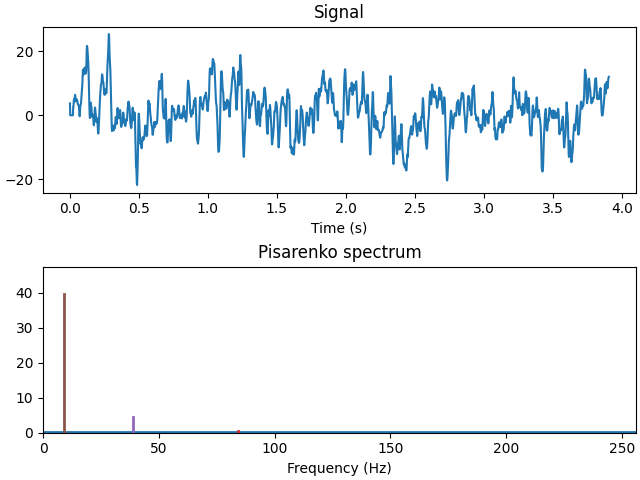


Recording 1: Baseline (no stimulation)
Estimated noise variance: 3.289392e-02
Estimated sinusoids (frequency [Hz], amplitude):
  9.023 Hz,  3.962641e+01
  38.888 Hz,  4.333258e+00
  84.362 Hz,  3.920102e-01
  130.103 Hz,  5.780038e-02
  177.972 Hz,  7.938409e-03


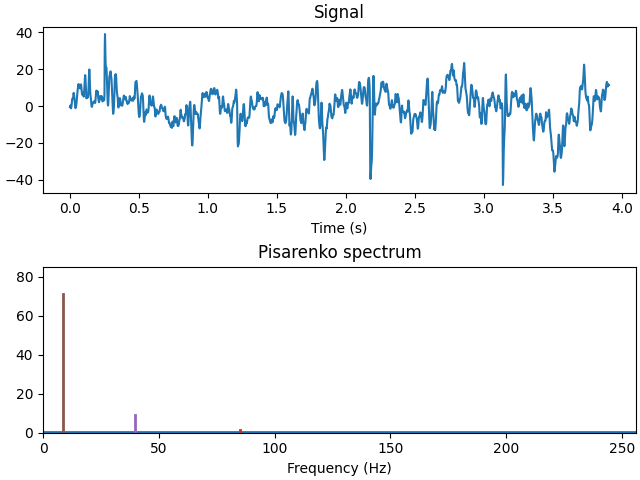


Recording 2: 1-Hz stimulation
Estimated noise variance: 6.120942e-02
Estimated sinusoids (frequency [Hz], amplitude):
  8.726 Hz,  7.099315e+01
  39.609 Hz,  9.018498e+00
  85.029 Hz,  1.051686e+00
  132.825 Hz,  1.562141e-01
  181.141 Hz,  2.685428e-02


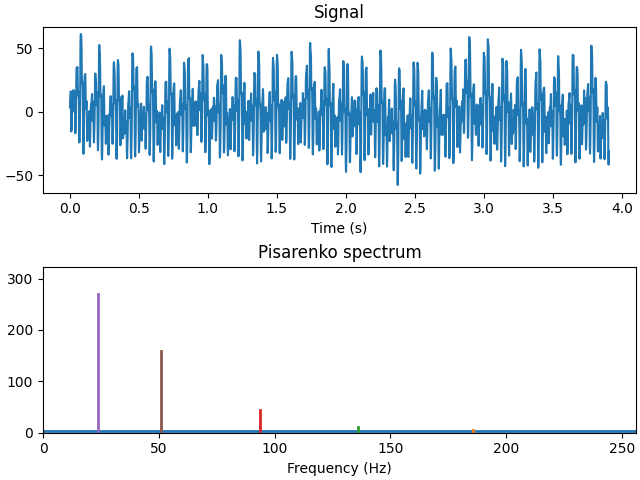


Recording 3: 100-Hz stimulation
Estimated noise variance: 3.762942e+00
Estimated sinusoids (frequency [Hz], amplitude):
  23.537 Hz,  2.657269e+02
  50.792 Hz,  1.549611e+02
  93.570 Hz,  3.928443e+01
  136.092 Hz,  7.673892e+00
  185.887 Hz,  1.335573e+00


In [20]:
# Apply Pisarenko with 5 sinusoids to each EEG recording and report parameters
p = 5
titles = ['Baseline (no stimulation)', '1-Hz stimulation', '100-Hz stimulation']

for k in range(eeg.shape[1]):
    f_est, amp_est, noise_var = pisarenko(eeg[:, k], p, fs, Aff=1)
    # ensure arrays and sort by frequency
    f_est = np.asarray(f_est)
    amp_est = np.asarray(amp_est)
    order = np.argsort(f_est)
    f_est = f_est[order]
    amp_est = amp_est[order]

    print(f"\nRecording {k+1}: {titles[k]}")
    print(f"Estimated noise variance: {noise_var:.6e}")
    print("Estimated sinusoids (frequency [Hz], amplitude):")
    for fi, ai in zip(f_est, amp_est):
        print(f"  {fi:.3f} Hz,  {ai:.6e}")

**Question 4.3.** Interpret the estimation results -- which stimulation frequency appears to effectively influence brain activity?

**Answer 4.3.** The Pisarenko estimates show prominent spectral components at ~100 Hz (and harmonics) with large amplitudes and reduced noise variance for the 100‑Hz stimulation recording. This indicates a clear stimulation‑related effect. The 1‑Hz recording shows at best weak/ambiguous components near 1 Hz, and the baseline shows no stimulation‑related line. Therefore the 100‑Hz stimulation is the one that effectively influences the EEG.

### Have a good session, and don't hesitate to ask questions!